### Using dark emulator to describe the DMASS clustering/lensing signals

The instructions for installation are one the README of the Github repo: https://github.com/DarkQuestCosmology/dark_emulator_public
and also described on the documentation:
https://dark-emulator.readthedocs.io/en/latest/

For my given conda set-up, conda install failed, but pip worked. Check that it has properly installed by running `import dark_emulator` in ipython or ipython notebook. I currently get a message that `colossus is not installed.` but not sure yet whether this will impact our usage of dark emulator.

Sujeong has produced blinded Y1 DMASS correlation measurements, which live in
`/users/PCON0003/cond0080/DMASS/blinded_dmass_y1_small_scale` so these are what we will try to fit with the dark emulator.

In order to understand how the model works, you will need to do background reading on the halo model and halo occupation distribution (HOD). Will update with some good references here (e.g., the DES Y3 galaxy-galaxy lensing paper by Zacharegkas+ https://arxiv.org/abs/2106.08438 is one place to look but you may need to do a deeper search to get more details).

In [1]:
%pylab inline
import os
import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt
import dark_emulator
from dark_emulator import model_hod

Populating the interactive namespace from numpy and matplotlib
colossus is not installed.


In [2]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.figsize'] = (10,6)

### Testing dark emulator
We will eventually want to fit HOD parameters to a galaxy-galaxy lensing signal in DeltaSigma(R), so the first part of one of their notebooks shows the steps for setting these parameters and plotting them. This is reproduced below.

To learn what the actual parameters are, you will need to check the documentation. For example, two cells below there is an array called `cparam` which is passed to a function called `set_cosmology` which has documentation here: https://dark-emulator.readthedocs.io/en/latest/dark_emulator.model_hod.hod_interface.html#dark_emulator.model_hod.hod_interface.darkemu_x_hod.set_cosmology

In [3]:
# Initialization of a python class that sets cosmology, halo occupation distribution parameters (HOD), and more
hod = model_hod.darkemu_x_hod({"fft_num":8})

initialize cosmo_class
Initialize pklin emulator
initialize propagator emulator
Initialize sigma_d emulator
initialize cross-correlation emulator
initialize auto-correlation emulator
Initialize sigmaM emulator
initialize xinl emulator


In [4]:
cparam = np.array([0.02225,0.1198,0.6844,3.094,0.9645,-1.])
hod.set_cosmology(cparam)

gparam = {"logMmin":13.13, "sigma_sq":0.22, "logM1": 14.21, "alpha": 1.13, "kappa": 1.25, # HOD parameters
           "poff": 0.2, "Roff": 0.1, # off-centering parameters p_off is the fraction of off-centered galaxies. Roff is the typical off-centered scale with respect to R200m.
           "sat_dist_type": "emulator", # satellite distribution. Chosse emulator of NFW. In the case of NFW, the c-M relation by Diemer & Kravtsov (2015) is assumed.
           "alpha_inc": 0.44, "logM_inc": 13.57} # incompleteness parameters. For details, see More et al. (2015)
hod.set_galaxy(gparam)

INFO:root:Got same cosmology. Keep quantities already computed.


DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=18.0 to DejaVu Sans ('/users/PCON0003/cond0080/.conda/envs/py3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
DEBUG:matplotlib.font_manager:findfont: Matching :family=STIXGeneral:style=normal:variant=normal:weight=normal:stretch=normal:size=18.0 to STIXGeneral ('/users/PCON0003/cond0080/.conda/envs/py3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf') with score of 0.050000
DEBUG:matplotlib.font_manager:findfont: Matching :family=STIXGeneral:style=italic:variant=normal:weight=normal:stretch=normal:size=18.0 to STIXGeneral ('/users/PCON0003/cond0080/.conda/envs/py3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf') with score of 0.050000
DEBUG:matplotlib.font_manager:findfont: Matching :family=STIXGeneral:style=normal:variant=normal:weight=bold:stretch=

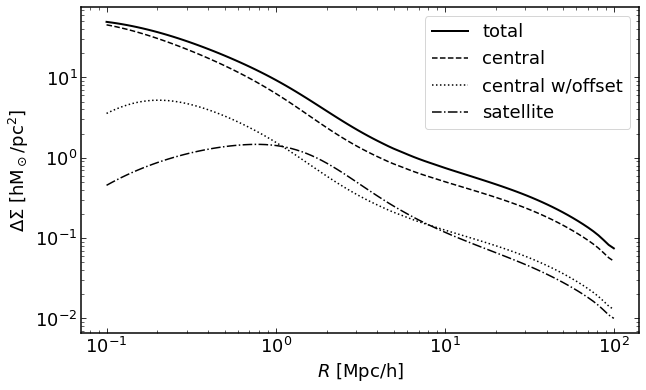

In [5]:
# Currently getting a lot of matplotlib debug messages I need to figure out
redshift = 0.55  # This is roughly the midpoint of the CMASS redshift range (0.43-0.7)
r = np.logspace(-1,2,100)  # Somewhat arbitrary choice of physical separation "r"

plt.figure(figsize=(10,6))

# Plot each of the different halo model components
plt.loglog(r, hod.get_ds(r, redshift), linewidth = 2, color = "k", label = "total")
plt.loglog(r, hod.get_ds_cen(r, redshift), "--", color = "k", label = "central")
plt.loglog(r, hod.get_ds_cen_off(r, redshift), ":", color = "k", label = "central w/offset")
plt.loglog(r, hod.get_ds_sat(r, redshift), "-.", color = "k", label = "satellite")

plt.xlabel(r"$R$ [Mpc/h]")
plt.ylabel(r"$\Delta\Sigma$ [hM$_\odot$/pc$^2$]")
plt.legend()

### Fitting the dark emulator model to the DMASS Y1 galaxy-galaxy lensing signal

We want to fit the model to our signal but we have the model for $\Delta \Sigma (R)$ and we have the measured DMASS Y1 galaxy-galaxy lensing signal in $\gamma_{T}(\theta)$. We need to convert one to the other.

In [6]:
fdir = '/users/PCON0003/cond0080/DMASS/blinded_dmass_y1_small_scale'
filein = 'simulated_y1_dmass_3x2pt_baseline_small_scales.fits'

# Open up the file
hdu = fits.open(os.path.join(fdir, filein))

# The galaxy-galaxy lensing signal is stored here with the name "galaxy_shear_xi"
# Ignore the other extensions for now, they correspond to cosmic shear and galaxy clustering
ggl_hdu_header = hdu[3].header
ggl_hdu = hdu[3].data

# Printing ggl_hdu_header indicates that ggl_hdu contains bin1, bin2, angbin, value, ang
# where bin1 is the redshift bin number for the foreground positions (here for DMASS this is always 1)
# bin2 is the redshift bin number for the background source galaxy shapes (there are four source redshift bins in total)
print(ggl_hdu_header)

XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                   40 / length of dimension 1                          NAXIS2  =                  120 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                    5 / number of table fields                         2PTDATA =                    T                                                  EXTNAME = 'galaxy_shear_xi'                                                     QUANT1  = 'GPR     '                                                            QUANT2  = 'G+R     '                                                            KERNEL_1= 'nz_lens '                    

Printing ggl_hdu_header indicates that ggl_hdu contains bin1, bin2, angbin, value, ang where:
* bin1 is the redshift bin number for the foreground positions (here for DMASS this is always 1)
* bin2 is the redshift bin number for the background source galaxy shapes (there are four source redshift bins in total)
* angbin is the number of the theta bin
* value is $\gamma_{T}$ for the given theta bin
* ang is the theta value.

In [7]:
# Helpful to take one set of gamma_T points (e.g., DMASS cross-correlated with redshift bin 4) and plot them
# Next exercise here is to either convert the gamma_T to Delta Sigma or vice-versa...